In [43]:
# Feature selection scrapbook:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pybedtools
import pandas as pd
import numpy as np
import umap
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import maxabs_scale

In [44]:
total_df = pd.read_pickle("data/iap_variances.pkl")
total_df["val_result"] = total_df["val_result"].replace("-1", "Untested")
rand_df = pd.read_pickle("data/rand_variances.pkl")

In [45]:
total_df["integer_encodings"] = total_df["val_result"]
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Untested", -1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("True ME", 1)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("False-positive", 2)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace("Tissue-specific", 3)
total_df.loc[:, "integer_encodings"] = \
    total_df.loc[:, "integer_encodings"].replace(3, 1)
cols = []
cols = total_df.columns.tolist()
cols = cols[:7] + [cols[-1]] + cols[7:-1]
total_df = total_df[cols]

# Generating validation dataframe for model training:
val_df = total_df[total_df.val_result != "Untested"]
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)

In [54]:
# selector = SelectKBest(mutual_info_classif, k=30)
selector = VarianceThreshold(threshold=0)
selector.fit(total_df.iloc[:, 8:])
support = selector.get_support(indices=True)

# Extracting high variance & normalising:
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]
kbest_val = val_df.iloc[:, 8:][val_df.iloc[:, 8:].columns[support]]
kbest_rand = rand_df.iloc[:, 6:][rand_df.iloc[:, 6:].columns[support]]

print(kbest_total.shape)
print(kbest_val.shape)

(8059, 28)
(97, 28)


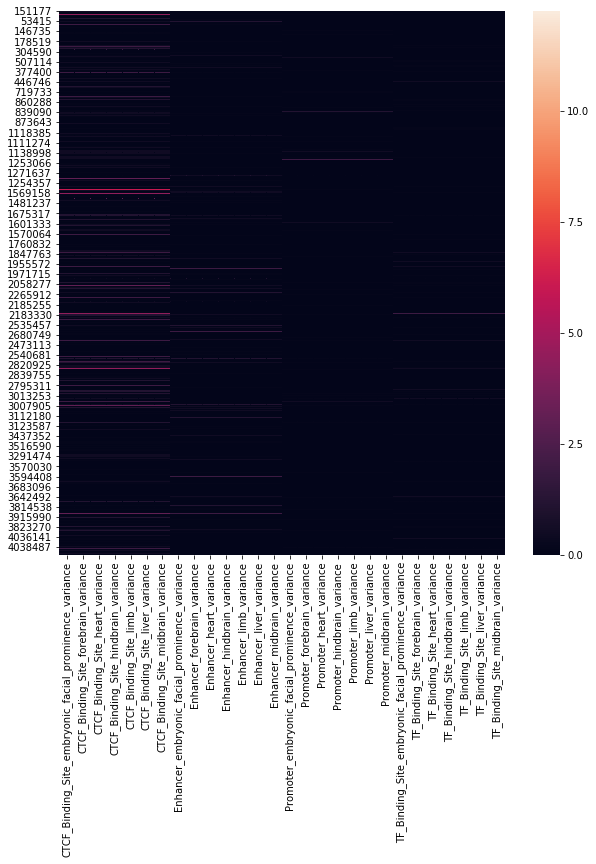

In [55]:
sns.heatmap(total_df.iloc[:, 8:])

In [52]:
kbest_total

,CTCF_Binding_Site_embryonic_facial_prominence_variance,CTCF_Binding_Site_forebrain_variance,CTCF_Binding_Site_heart_variance,CTCF_Binding_Site_hindbrain_variance,CTCF_Binding_Site_limb_variance,CTCF_Binding_Site_liver_variance,CTCF_Binding_Site_midbrain_variance
151177,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449
25136,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449
159399,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
160006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
91370,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449
...,...,...,...,...,...,...,...
4180871,0.489796,0.489796,0.489796,0.489796,0.489796,0.489796,0.489796
4041241,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4069873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4041384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [56]:
reducer = umap.UMAP(n_neighbors=15, n_components=2, verbose=False, random_state=1)
reducer.fit(kbest_total, total_df.loc[:, "integer_encodings"])

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
     learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
     metric_kwds=None, min_dist=0.1, n_components=2, n_epochs=None,
     n_neighbors=15, negative_sample_rate=5, random_state=1,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None,
     target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
     transform_seed=42, verbose=False)

In [57]:
embedding_total = reducer.transform(kbest_total)
embedding_val = reducer.transform(kbest_val)
embedding_rand = reducer.transform(kbest_rand)

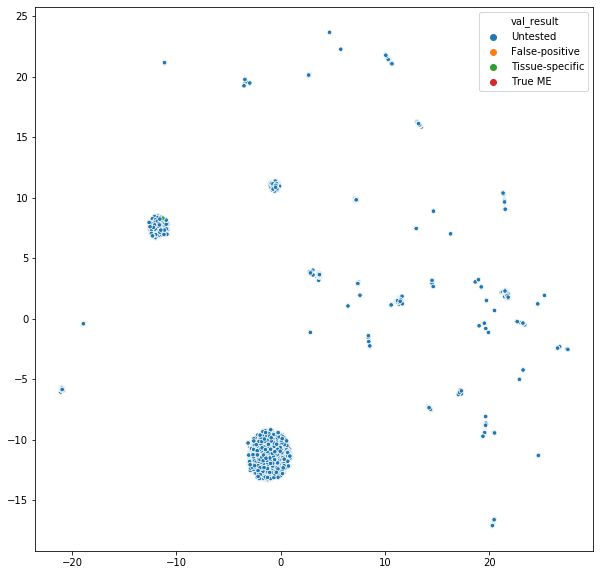

In [58]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10, 10]
sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1], hue=total_df["val_result"], s=20, marker='o')

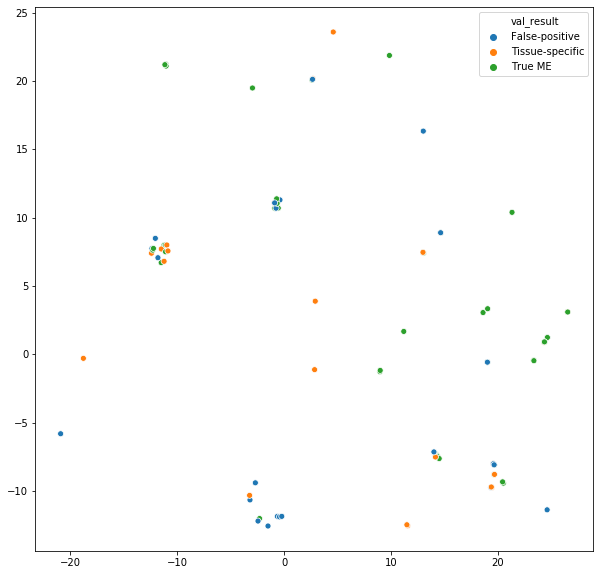

In [59]:
sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["val_result"])

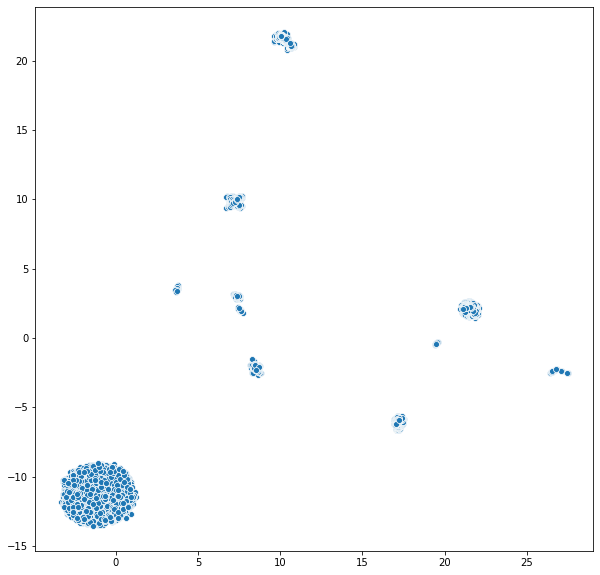

In [60]:
sns.scatterplot(x=embedding_rand[:, 0], y=embedding_rand[:, 1])

In [61]:
from sklearn.svm import SVC
class_weight= {1: 1, 2: 2.5}
clf = SVC(gamma=0.01, class_weight=class_weight)
val_df.loc[:, "integer_encodings"] = \
    val_df.loc[:, "integer_encodings"].replace(3, 2)
clf.fit(embedding_val, val_df["integer_encodings"])
clf.score(embedding_val, val_df["integer_encodings"])

0.7731958762886598

In [62]:
h = .1  # step size in the mesh
x_min, x_max = embedding_val[:, 0].min() - 1, embedding_val[:, 0].max() + 1
y_min, y_max = embedding_val[:, 1].min() - 1, embedding_val[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

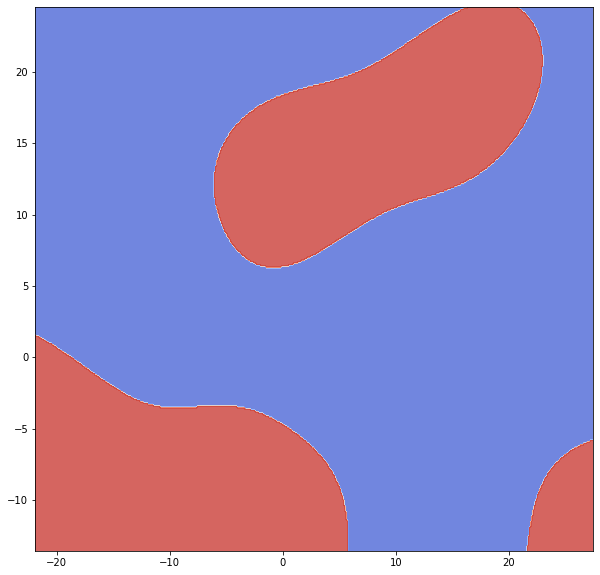

In [63]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

In [64]:
predictions = pd.Series(clf.predict(embedding_total), index=total_df.index)
predictions = predictions.replace(1, "True ME")
predictions = predictions.replace(2, "Not True ME")
predictions = predictions.replace(3, "Not True ME")
predictions.value_counts()

Not True ME    5014
True ME        3045
dtype: int64

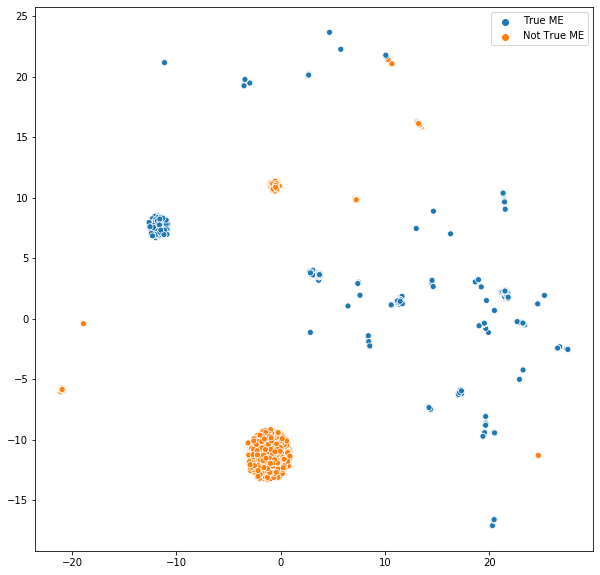

In [65]:
sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1], hue=predictions)

In [76]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(embedding_total)
total_category_labels = pd.Series(kmeans.labels_)
total_category_labels.index = total_df["element_id"].astype(int).to_list()

rand_category_labels = pd.Series(kmeans.predict(embedding_rand))
rand_category_labels.index = rand_df["element_id"].astype(int).to_list()

sorted_total_df = total_df.copy(deep=True)
sorted_total_df["cluster_assignments"] = total_category_labels

sorted_rand_df = rand_df.copy(deep=True)
sorted_rand_df["cluster_assignments"] = rand_category_labels

hue_order = ["A", "B", "C", "D", "E"]

In [77]:
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(0, "A")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(1, "B")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(2, "C")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(3, "D")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(4, "E")
sorted_total_df.loc[:, "cluster_assignments"] = \
    sorted_total_df.loc[:, "cluster_assignments"].replace(5, "F")

In [78]:
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(0, "A")
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(1, "B")
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(2, "C")
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(3, "D")
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(4, "E")
sorted_rand_df.loc[:, "cluster_assignments"] = \
    sorted_rand_df.loc[:, "cluster_assignments"].replace(5, "F")

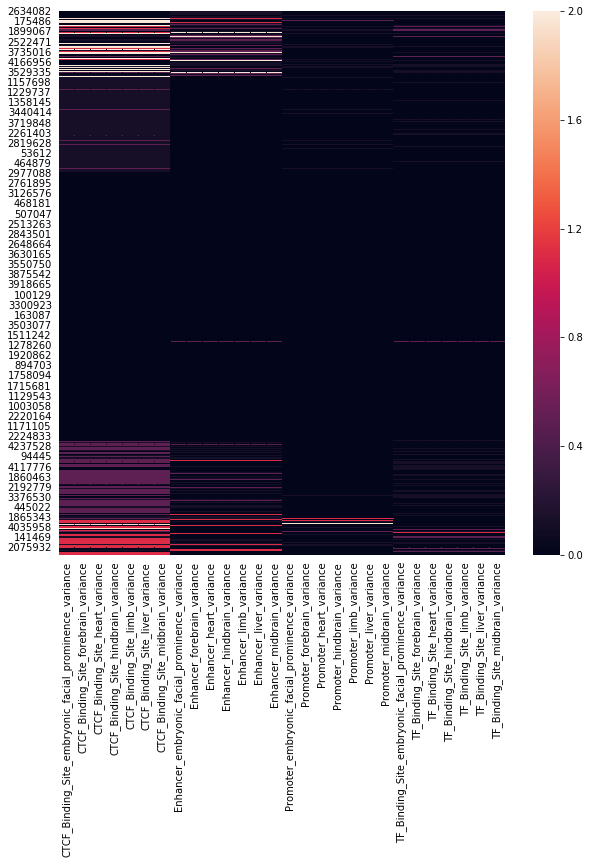

In [79]:
sorted_total_df = sorted_total_df.sort_values(by=["cluster_assignments"])
ax = sns.heatmap(sorted_total_df.iloc[:, 8:-1], vmin=0, vmax=2)
ax.tick_params(left=False, bottom=False)

In [80]:
sorted_total_df

,chrom,start,end,element_id,length,strand,val_result,integer_encodings,CTCF_Binding_Site_embryonic_facial_prominence_variance,CTCF_Binding_Site_forebrain_variance,...,Promoter_liver_variance,Promoter_midbrain_variance,TF_Binding_Site_embryonic_facial_prominence_variance,TF_Binding_Site_forebrain_variance,TF_Binding_Site_heart_variance,TF_Binding_Site_hindbrain_variance,TF_Binding_Site_limb_variance,TF_Binding_Site_liver_variance,TF_Binding_Site_midbrain_variance,cluster_assignments
2634082,chr3,104581221,104581672,2634082,452,-,Untested,-1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A
2817412,chr4,59498652,59499129,2817412,478,-,Untested,-1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A
2956139,chr4,135367251,135367718,2956139,468,-,Untested,-1,1.959184,1.959184,...,0.000000,0.000000,0.489796,0.489796,0.489796,0.489796,0.489796,0.489796,0.489796,A
2851296,chr4,82729127,82729593,2851296,467,-,Untested,-1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,A
351443,chr10,16644775,16645154,351443,380,+,Untested,-1,0.122449,0.122449,...,0.000000,0.000000,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449,0.122449,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548143,chr10,127529581,127529713,548143,133,-,Untested,-1,0.122449,0.122449,...,0.489796,0.489796,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,E
3251097,chr5,138702261,138702572,3251097,312,-,Untested,-1,0.122449,0.122449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,E
3246679,chr5,136949756,136950065,3246679,310,+,Untested,-1,1.102041,1.102041,...,0.122449,0.122449,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,E
3144687,chr5,91714665,91714997,3144687,333,+,Untested,-1,0.122449,0.122449,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,E


In [69]:
pyroval_bed = pybedtools.BedTool("data/IAP_validation.July2019.stranded.with_IDs.bed")
names = ["chrom", "start", "end", "strand", "gene",
         "blueprint", "ear", "b_cell", "val_status", "element_id"]
pyroval_df = pyroval_bed.to_dataframe(names=names)
pyroval_df = pyroval_df[pyroval_df["ear"] != "NaN"]
pyroval_df = pyroval_df[pyroval_df["element_id"] != "."]
pyroval_df = pyroval_df[pyroval_df["chrom"] != "chrX"]

pyroval_df.index = pyroval_df["element_id"].astype(int).to_list()
pyroval_df

,chrom,start,end,strand,gene,blueprint,ear,b_cell,val_status,element_id
353879,chr10,18139121,18139597,+,Ect2l,28.479482,12.356460,NaN,True ME,353879
363443,chr10,23726341,23726813,+,Rps12,52.083333,12.379583,NaN,True ME,363443
420013,chr10,59381799,59387060,+,P4ha1,29.895833,12.489792,NaN,True ME,420013
457485,chr10,78020226,78025621,+,Aire,30.208333,12.930833,NaN,True ME,457485
499010,chr10,99599559,99600037,+,Gm20110,29.166667,19.832917,NaN,True ME,499010
...,...,...,...,...,...,...,...,...,...,...
3906187,chr8,72024783,72033082,-,Cyp4f18,41.020833,4.624444,7.175556,False-positive,3906187
3906764,chr8,72228229,72232950,-,Fam32a,30.104167,0.551666,5.849000,False-positive,3906764
4200422,chr9,103108602,103109112,+,Rab6b,37.500000,44.126670,NaN,True ME,4200422
4245666,chr9,123742717,123749810,-,Ccr9,36.875000,1.207500,12.340000,Tissue-specific,4245666


In [70]:
sorted_total_df["ear"] = pyroval_df["ear"]
blueprint_categories = sorted_total_df[sorted_total_df.ear.notnull()]
blueprint_categories["cluster_assignments"].value_counts(sort=False).sort_index()

A    19
B    20
C     9
D    19
E    26
Name: cluster_assignments, dtype: int64

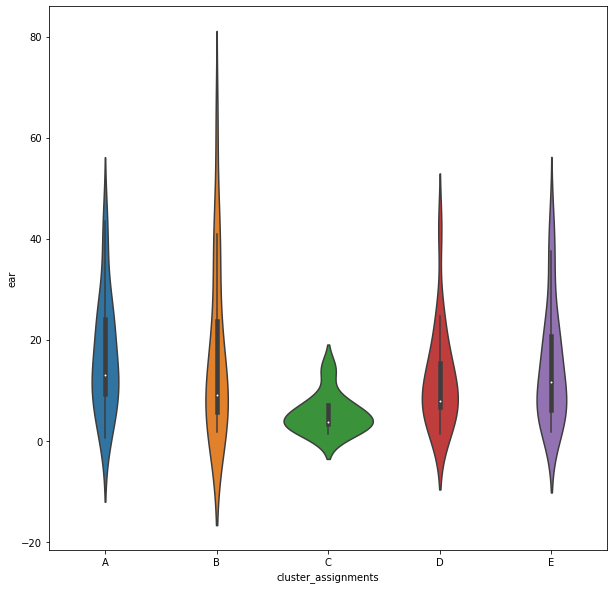

In [82]:
sns.violinplot(x="cluster_assignments", y="ear", data=blueprint_categories, order=hue_order)

In [72]:
bool_mask = sorted_total_df["cluster_assignments"] == "C"
high_variability_iaps = pybedtools.BedTool.from_dataframe(sorted_total_df[bool_mask].iloc[:, 0:6])
high_variability_iaps.saveas('data/high_variability_iaps.bed')

<BedTool(data/high_variability_iaps.bed)>

[Text(0.5, 1.0, 'IAPs')]

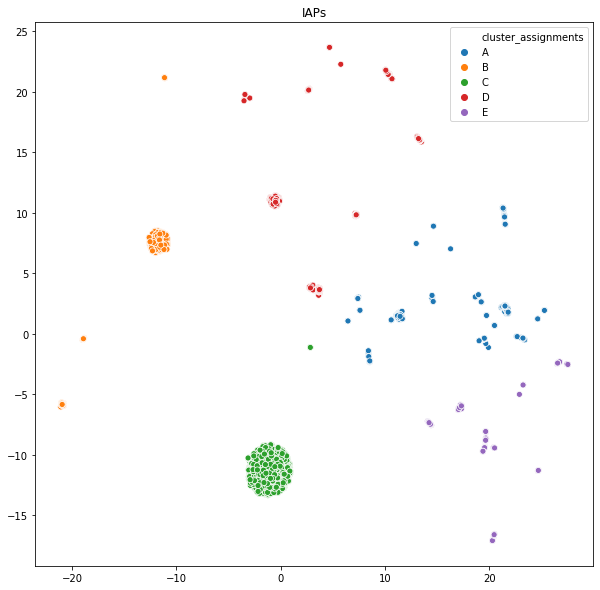

In [73]:
# Solo LTR v intact IAPs - see if patterns are conserved across different elements
ax = sns.scatterplot(x=embedding_total[:, 0], y=embedding_total[:, 1],
                     hue=sorted_total_df["cluster_assignments"], hue_order = hue_order)
ax.set(title="IAPs")

[Text(0.5, 1.0, 'Random genomic intervals')]

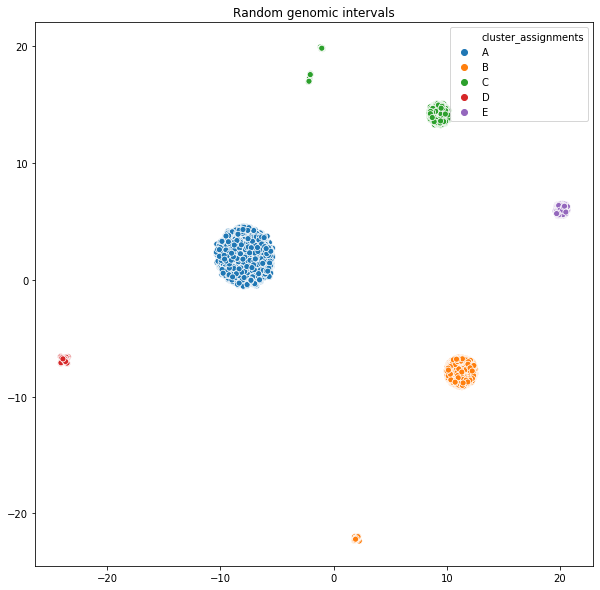

In [20]:
ax = sns.scatterplot(x=embedding_rand[:, 0], y=embedding_rand[:, 1],
                     hue=sorted_rand_df["cluster_assignments"], hue_order = hue_order)
ax.set(title="Random genomic intervals")

In [21]:
def int_filter(x):
    if 0 < x <= 800:
        return 'solo_iap'
    elif 500 < x:
        return 'int_iap'
    else:
        return None

sorted_total_df["iap_status"] = sorted_total_df["length"].apply(int_filter)
sorted_rand_df["iap_status"] = sorted_rand_df["length"].apply(int_filter)

[(0, 3200)]

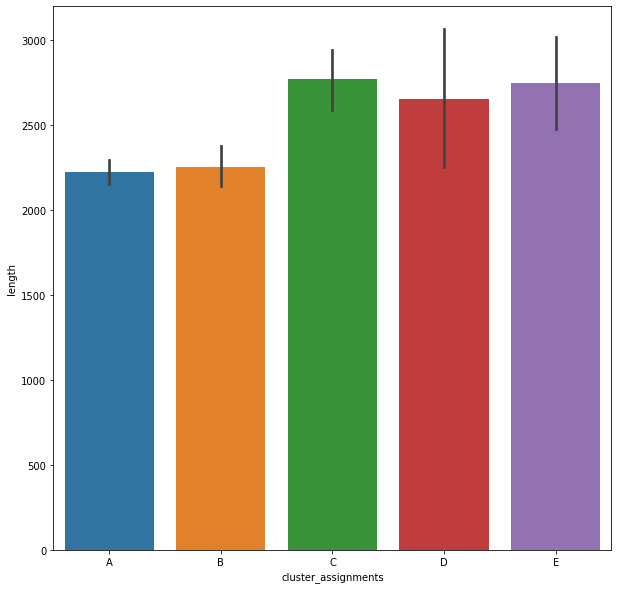

In [22]:
ax = sns.barplot(x="cluster_assignments", y="length",
                 data=sorted_total_df, order = hue_order)
ax.set(ylim=(0, 3200))

[(0, 3200)]

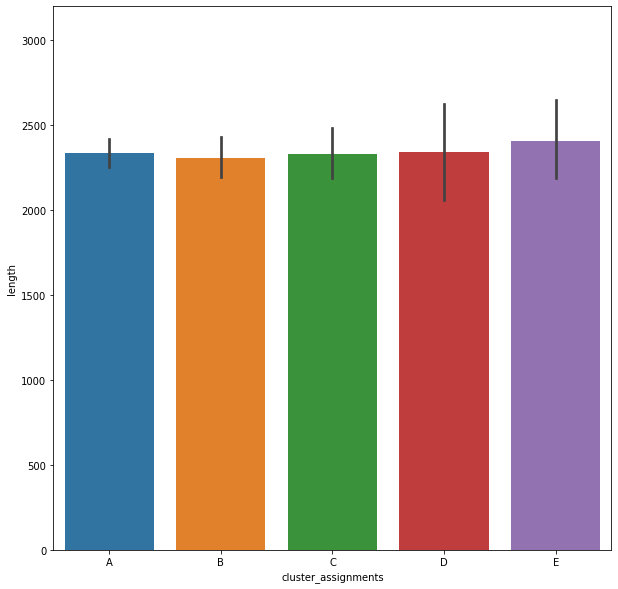

In [23]:
ax = sns.barplot(x="cluster_assignments", y="length",
                 data=sorted_rand_df, order=hue_order)
ax.set(ylim=(0, 3200))

[(0, 5000)]

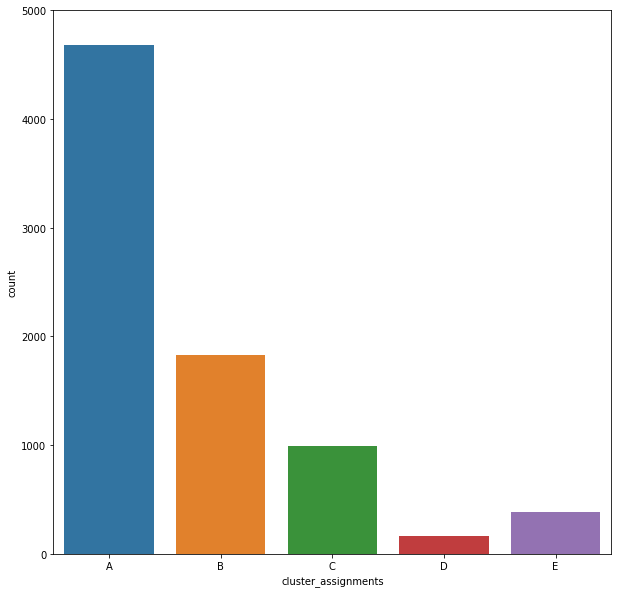

In [24]:
ax = sns.countplot(x="cluster_assignments", data=sorted_total_df, order=hue_order)
ax.set(ylim=(0, 5000))

[(0, 5000)]

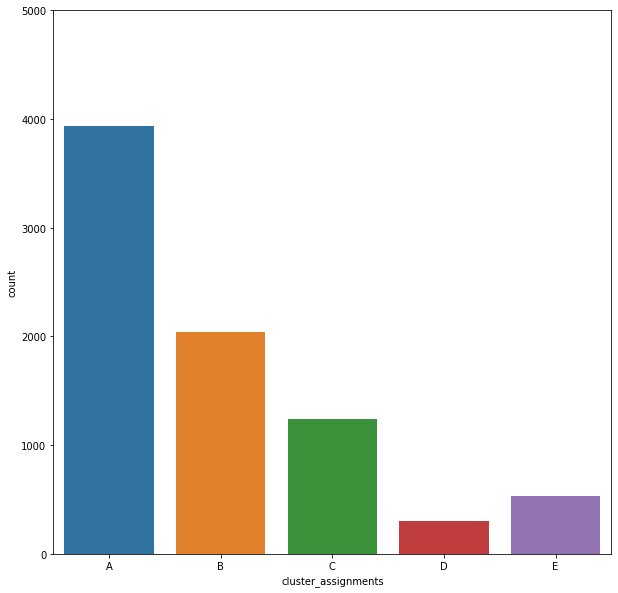

In [25]:
ax = sns.countplot(x="cluster_assignments", data=sorted_rand_df, order=hue_order)
ax.set(ylim=(0, 5000))

In [ ]:
col_names = ["kmer", "ltr_id", "element_id", "gene"]
jellyfish_kmers = pd.read_csv('data/jellyfish_kmers.curated_seqs.all_hits.tsv', sep='\t', names=col_names)
jellyfish_kmers.index = jellyfish_kmers["element_id"].astype(int).to_list()
jellyfish_element_ids = jellyfish_kmers["element_id"].astype(int).to_list()
jellyfish_array = np.asarray(jellyfish_element_ids)

In [ ]:
def generate_kmer_labels(feature, jellyfish_kmers):
    if feature.element_id in jellyfish_kmers:
        feature["kmer_value"] = "kmer present"
    else:
        feature["kmer_value"] = "kmer not present"
    return feature["kmer_value"]

kmer_total = total_df.apply((lambda x: generate_kmer_labels(x, jellyfish_array)), axis=1)
kmer_val = val_df.apply((lambda x: generate_kmer_labels(x, jellyfish_array)), axis=1)

In [ ]:
kmer_embeddings = embedding_total[kmer_total.kmer_value == "kmer present", :]
kmer_embeddings.shape

In [ ]:
sns.scatterplot(x=kmer_embeddings[:, 0], y=kmer_embeddings[:, 1])

In [ ]:
sns.scatterplot(x=embedding_val[:, 0], y=embedding_val[:, 1], hue=val_df["kmer_value"])

In [ ]:
reducer_labelspread = umap.UMAP(n_neighbors=15, verbose=False, random_state=1)
reducer_labelspread.fit(kbest_total, numerical_labels)

In [ ]:
def mi_kbest_selector(data, labels, k=10):
    selector = SelectKBest(mutual_info_classif, k)
    selector.fit(data, labels)
    return data[data.columns[selector.get_support(indices=True)]], selector.get_support(indices=True)

k_best_df, support = mi_kbest_selector(val_df.iloc[:, 8:], val_df["integer_encodings"])
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(val_df.iloc[:, 8:], val_df["integer_encodings"])
selector = SelectFromModel(clf, prefit=True)
support = selector.get_support(indices=True)
kbest_total = total_df.iloc[:, 8:][total_df.iloc[:, 8:].columns[support]]

In [ ]:
from sklearn.semi_supervised import LabelSpreading
label_prop_model = LabelSpreading(alpha=0.1, kernel="knn", n_neighbors=50, max_iter=300)
label_prop_model.fit(kbest_total, total_df.loc[:, "integer_encodings"])

In [ ]:
numerical_labels = label_prop_model.predict(kbest_total)
predictions = pd.Series(label_prop_model.predict(kbest_total), index=total_df.index)
predictions.value_counts()

In [ ]:
predictions = predictions.replace(1, "True ME")
predictions = predictions.replace(2, "False-positive")
predictions = predictions.replace(3, "Tissue-specific")
predictions.value_counts()

In [ ]:
label_prop_model.label_distributions_